# Drive

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install

In [3]:
!pip install imgaug==0.2.5

!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2


     |████████████████████████████████| 563kB 3.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-cp36-none-any.whl size=561439 sha256=bd6c4eee80c83bd436af41cb06a037aee82defc9fda2f98ee7abfaf8edce9feb
  Stored in directory: /root/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae0b
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 28.2MB 138kB/s 


In [4]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 50.2MB/s 
  Found existing installation: opencv-python 4.2.0.34
    Uninstalling opencv-python-4.2.0.34:
      Successfully uninstalled opencv-python-4.2.0.34


     |████████████████████████████████| 30.6MB 187kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
pip install --upgrade pip

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


# Draw the epipolar lines

Find as many possible matches between two images in order to to calculate the fundamental matrix. Use SIFT descriptors with FLANN based matcher and ratio test.

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# print(cv2.__version__)
# img1 = cv2.imread('drive/My Drive/aki1.jpeg',0)  #queryimage # left image
# img2 = cv2.imread('drive/My Drive/aki2.jpeg',0) #trainimage # right image
img1 = cv2.imread('drive/My Drive/room1.jpeg',0)  #queryimage # left image
img2 = cv2.imread('drive/My Drive/room.jpeg',0) #trainimage # right image

sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(p,n) in enumerate(matches):
    if p.distance < 0.8*n.distance:
        good.append(p)
        pts2.append(kp2[p.trainIdx].pt)
        pts1.append(kp1[p.queryIdx].pt)

      

We have a list of the best matches from both the images. Next we compute the fundamental matrix F from a pair of normalized images with at least 8 corresponding points

In [38]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT )
# F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC )


print(F)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

[[ 2.19587494e-08  2.04135480e-06 -8.22679534e-04]
 [-3.06841124e-07  3.97401666e-08 -4.02175191e-03]
 [ 1.50601756e-04  1.77330969e-03  1.00000000e+00]]


In [0]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

Draw the epipolar lines on both images

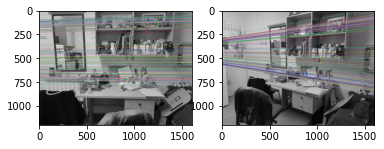

In [40]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
left_image,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
right_image,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(left_image)
# plt.savefig('epipolar lines left.png')
plt.subplot(122),plt.imshow(right_image)
plt.savefig('epipolar lines.png')
plt.show()


# Brute-Force Matching with SIFT Descriptors and Ratio Test

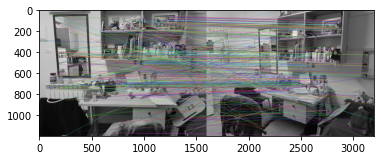

(<matplotlib.image.AxesImage at 0x7f8428780b70>, None)

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('drive/My Drive/room1.jpeg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('drive/My Drive/room.jpeg',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

# FLANN based Matcher

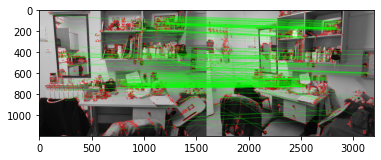

(<matplotlib.image.AxesImage at 0x7f84267af240>, None)

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('drive/My Drive/room1.jpeg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('drive/My Drive/room.jpeg',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

Given corresponding points m1,m2:
1.normalize image coordinates:
  compute centers and average distances for each of the two point sets
  calculate the normalizing transformations for each of the point sets:  after the transformation each set will have the mass center at the coordinate origin  and the average distance from the origin will be ~sqrt(2).
  
2.compute F with the normalized coordinates
form a linear system Ax=0: for each selected pair of points m1 , m2, the row of A(=a) represents the coefficients of equation: (m2, 1)'*F*(m1, 1) = 0. To save computation time, compute (At*A) instead of A and then solve (At*A)x=0.
take the last column of v as a solution of Af = 0. make F0 singular (of rank 2) by decomposing it with SVD, zeroing the last diagonal element of W and then composing the matrices back.
apply the transformation that is inverse to what we used to normalize the point coordinates
make F(3,3) = 1
return F.
